In [157]:
import pandas as pd

## Load data

### answer file

In [158]:
ANSWER_FILE = '../test_results/multi_hop/questions.csv'
ans_df = pd.read_csv(ANSWER_FILE)
ans_df.head()

,query,answer,question_type,evidence_list
0,Who is the individual associated with the cryp...,Sam Bankman-Fried,inference_query,3
1,Which individual is implicated in both inflati...,Donald Trump,inference_query,2
2,Who is the figure associated with generative A...,Sam Altman,inference_query,2
3,Do the TechCrunch article on software companie...,Yes,comparison_query,2
4,Which online betting platform provides a welco...,Caesars Sportsbook,inference_query,3


### RAG answer

In [159]:

RAG_ANSWER_FILE = '../test_results/multi_hop/RAG_result.csv'
rag_df = pd.read_csv(RAG_ANSWER_FILE)
rag_df.head()

,Question,RAG Answer
0,Who is the individual associated with the cryp...,Sam Bankman-Fried
1,Which individual is implicated in both inflati...,Trump
2,Who is the figure associated with generative A...,Sam Altman
3,Do the TechCrunch article on software companie...,Insufficient information
4,Which online betting platform provides a welco...,BetMGM


### No context answer

In [160]:
NO_CONTEXT_FILE = '../test_results/multi_hop/no_context_result.csv'
no_context_df = pd.read_csv(NO_CONTEXT_FILE)
no_context_df.head()

,Question,RAG Answer
0,Who is the individual associated with the cryp...,Insufficient information
1,Which individual is implicated in both inflati...,Insufficient information
2,Who is the figure associated with generative A...,Insufficient information
3,Do the TechCrunch article on software companie...,Insufficient information
4,Which online betting platform provides a welco...,Insufficient information


### Graph RAG answer

In [161]:
subdir = ''
GRAPH_RAG_FILE = '../test_results/multi_hop/' + subdir + 'GraphRAG_results.csv'
graphrag_df = pd.read_csv(GRAPH_RAG_FILE)
graphrag_df.head(5)

,Question,Graph RAG answer
0,Who is the individual associated with the cryp...,Sam Bankman-Fried
1,Which individual is implicated in both inflati...,Donald Trump
2,Who is the figure associated with generative A...,Sam Altman
3,Do the TechCrunch article on software companie...,Insufficient information
4,Which online betting platform provides a welco...,Caesars Sportsbook


### Graph RAG with graph explore

In [162]:
GRAPH_EXPLORE_FILE = '../test_results/multi_hop/graph_explore/GraphRAG_results.csv'
graph_explore_df = pd.read_csv(GRAPH_EXPLORE_FILE)
graph_explore_df.head()

,Question,Graph RAG answer,Iteration,time
0,Who is the individual associated with the cryp...,Sam Bankman-Fried,0,37.237534
1,Which individual is implicated in both inflati...,Donald Trump,0,37.965694
2,Who is the figure associated with generative A...,Sam Altman,0,41.640990
3,Do the TechCrunch article on software companie...,Yes,0,48.165514
4,Which online betting platform provides a welco...,BetMGM Sportsbook,0,38.791165


## Analyze answers

In [163]:
question_types = ['inference_query', 'comparison_query', 'temporal_query', 'null_query', 'total']

def is_correct(answer1:str, answer2:str):
    return str(answer1).strip('.').lower() == str(answer2).strip('.').lower()


def add_info_to_test_df(test_df):
    num_answers = test_df.shape[0]
    test_df['answer'] = ans_df['answer'].iloc[:num_answers]
    test_df['question_type'] = ans_df['question_type'].iloc[:num_answers]
    test_df['correctness'] = test_df.apply(lambda row: is_correct(row.iloc[1], row['answer']), axis=1)


def cal_correct_rate(test_df, question_type = 'total'):
    """calculate correctness rate of test_df for a specific question type"""
    assert question_type in question_types, "invalid question type"

    num_answers = test_df.shape[0]

    right_answer_count = 0
    num_of_type_questions = 0
    
    for i in range(num_answers):
        if question_type == 'total' or test_df['question_type'][i] == question_type:
            num_of_type_questions += 1
            if test_df['correctness'][i]:
                right_answer_count += 1

    return right_answer_count / num_of_type_questions, num_of_type_questions

In [164]:
def correct_rates_test_df(test_df):
    add_info_to_test_df(test_df)

    columns = ['question type', 'correct rate', 'num of questions']
    correct_df = pd.DataFrame(columns=columns)

    for i in range(len(question_types)):
        type = question_types[i]
        correct_df.loc[i] = [type, cal_correct_rate(test_df, type)[0], cal_correct_rate(test_df, type)[1]]
    return correct_df

### calculate correctness rate of each data frames

In [165]:
rag_correct_df = correct_rates_test_df(rag_df)
rag_correct_df.head()

,question type,correct rate,num of questions
0,inference_query,0.848485,33
1,comparison_query,0.428571,35
2,temporal_query,0.391304,23
3,null_query,0.777778,9
4,total,0.590000,100


In [166]:
no_context_correct_df = correct_rates_test_df(no_context_df)
no_context_correct_df

,question type,correct rate,num of questions
0,inference_query,0.090909,33
1,comparison_query,0.000000,35
2,temporal_query,0.000000,23
3,null_query,1.000000,9
4,total,0.120000,100


In [167]:
graphrag_correct_df = correct_rates_test_df(graphrag_df)
graphrag_correct_df

,question type,correct rate,num of questions
0,inference_query,0.939394,33
1,comparison_query,0.457143,35
2,temporal_query,0.434783,23
3,null_query,1.000000,9
4,total,0.660000,100


In [168]:
explore_graph_correct_df = correct_rates_test_df(graph_explore_df)
explore_graph_correct_df

,question type,correct rate,num of questions
0,inference_query,0.909091,33
1,comparison_query,0.542857,35
2,temporal_query,0.478261,23
3,null_query,1.000000,9
4,total,0.690000,100


### plot result

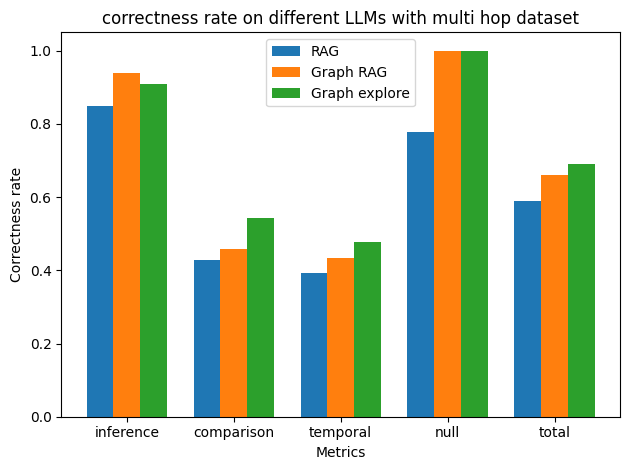

In [169]:
import matplotlib.pyplot as plt
import numpy as np


metrics = [q.split("_")[0] for q in question_types]
rag_correct = rag_correct_df.iloc[:, 1]
graph_rag_correct = graphrag_correct_df.iloc[:, 1]
no_context_correct = no_context_correct_df.iloc[:, 1]
graph_explore_correct = explore_graph_correct_df.iloc[:, 1]

x = np.arange(len(metrics))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
labels = ['RAG', 'Graph RAG', 'Graph explore']
# labels = ['qwen2', 'gpt-4o', 'llama 3.1']
rects1 = ax.bar(x - width, rag_correct, width, label=labels[0])
rects2 = ax.bar(x, graph_rag_correct, width, label=labels[1])
rects3 = ax.bar(x + width, graph_explore_correct, width, label=labels[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Metrics')
ax.set_ylabel('Correctness rate')
ax.set_title(f'correctness rate on different LLMs with multi hop dataset')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
# ax.bar_label(rects3, padding=3)

fig.tight_layout()

plt.show()


In [172]:
graph_explore_df[:50]

,Question,Graph RAG answer,Iteration,time,answer,question_type,correctness
0,Who is the individual associated with the cryp...,Sam Bankman-Fried,0,37.237534,Sam Bankman-Fried,inference_query,True
1,Which individual is implicated in both inflati...,Donald Trump,0,37.965694,Donald Trump,inference_query,True
2,Who is the figure associated with generative A...,Sam Altman,0,41.640990,Sam Altman,inference_query,True
3,Do the TechCrunch article on software companie...,Yes,0,48.165514,Yes,comparison_query,True
4,Which online betting platform provides a welco...,BetMGM Sportsbook,0,38.791165,Caesars Sportsbook,inference_query,False
5,Who is the individual alleged to have built a ...,Sam Bankman-Fried,0,32.755790,Sam Bankman-Fried,inference_query,True
6,Does the TechCrunch article on Twitch's subscr...,Yes,0,46.364660,Yes,comparison_query,True
7,Does 'The New York Times' article attribute th...,No,0,43.760442,Yes,comparison_query,False
8,What is the name of the organization discussed...,OpenAI,0,49.839989,OpenAI,inference_query,True
9,"Which company, as reported by both TechCrunch ...",Google,0,56.891946,Google,inference_query,True


In [173]:
first_iter_df = graph_explore_df[graph_explore_df['Iteration'] > 0]
first_iter_df
# first_iter_correct_df = correct_rates_test_df(first_iter_df)
# first_iter_correct_df

,Question,Graph RAG answer,Iteration,time,answer,question_type,correctness
10,Considering the information from a BBC article...,Insufficient information,2,113.124019,Insufficient Information,null_query,True
12,"After the TechCrunch report on October 7, 2023...",Insufficient information,2,169.425284,Yes,temporal_query,False
13,What is the first letter of the name of the co...,Insufficient information,1,74.493813,Insufficient Information,null_query,True
14,Does 'The Independent - Life and Style' articl...,Insufficient information,3,256.141766,Yes,comparison_query,False
16,"Which company, known for its dominance in the ...",Insufficient information,5,647.942153,Amazon,inference_query,False
17,Was there no change in the portrayal of Google...,Insufficient information,3,273.329597,no,temporal_query,False
18,Considering the features highlighted in an art...,Insufficient information,1,56.091380,Insufficient Information,null_query,True
19,Does the Sporting News article suggest that st...,Insufficient information,2,172.714560,no,comparison_query,False
20,Considering the information from an article in...,Insufficient information,1,66.038777,Insufficient Information,null_query,True
23,Was there inconsistency in Jada Pinkett Smith'...,Insufficient information,1,70.829818,no,temporal_query,False
